# Monthly DFM

In [1]:
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

* Load monthly (12 variables) and quarterly (1 variable) hard data from BuBa real-time database
* Transformations for stationarity

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    if transformation == 1:
        column = np.log(column).diff() * 100 * mult
        
    return column

In [3]:
def load_buba_data(vintage):
    
    # - Monthly data (BuBa) --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'../hard_data/vintages_monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.date.tolist(), freq='M')
    orig_m.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # - Quarterly data (BuBa) --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'../hard_data/vintages_quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract transformation information
    transform_q = orig_q.iloc[0, 1:]
    orig_q = orig_q.iloc[1:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.date.tolist(), freq='Q')
    orig_q.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q)

* Load seven vintages: 2008-01-01 (<=31Dec2007, forecast on the 1st of Jan 2008), 2008-01-16, 2008-02-01, 2008-02-16, 2008-03-01, 2008-03-16, 2008-04-01

In [4]:
# Load the vintages of data from BuBa
dta = {date: load_buba_data(date)
       for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']}

In [5]:
# Print some information about the base dataset
n, k = dta['2008-01-01'].dta_m.shape
start = dta['2008-01-01'].dta_m.index[0]
end = dta['2008-01-01'].dta_m.index[-1]

print(f'For vintage 2008-01-01, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

For vintage 2008-01-01, there are 12 series and 204 observations, over the period 1991-01 to 2007-12.


* Effect of transformations on the variables (visualization)

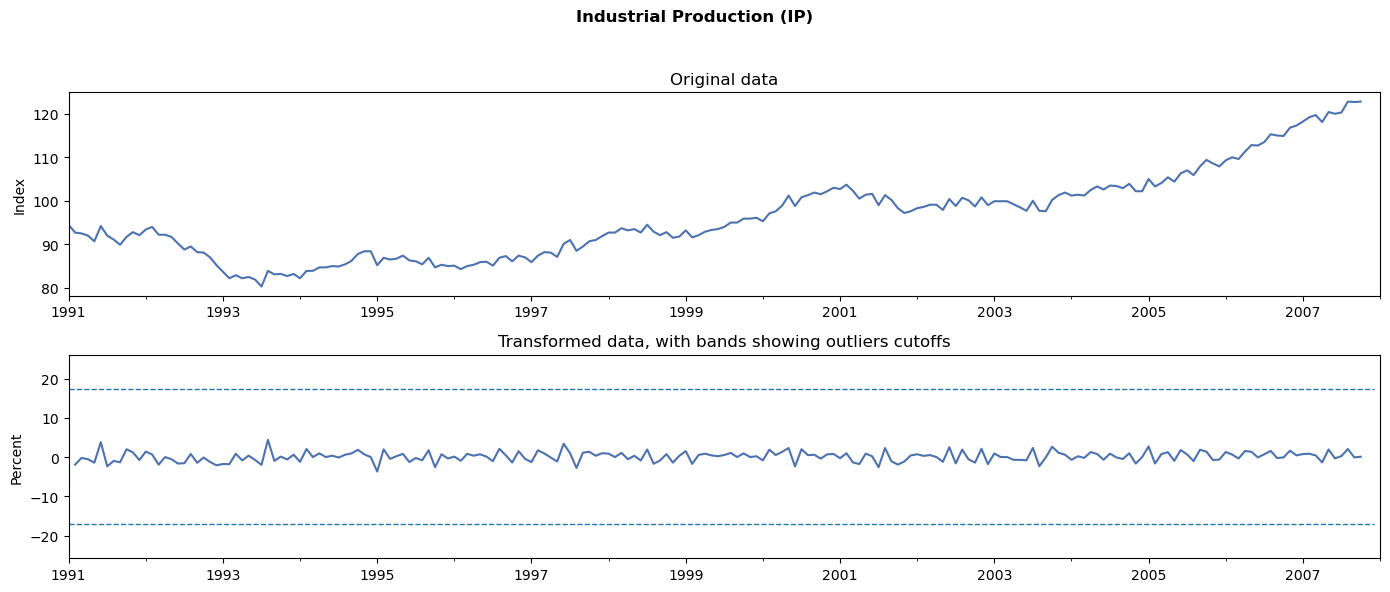

In [6]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 6))

    # Plot the raw data from the 01-Jan 2008 vintage, for:
    # 
    vintage = '2008-01-01'
    variable = 'IP'
    start = '1991-01'
    end = '2007-12'

    # 1. Plot the original dataset, for 1991-01 through 2007-12
    dta[vintage].orig_m.loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('1991','2008'), ylabel='Index')

    # 2. Plot the transformed data
    transformed = transform(dta[vintage].orig_m[variable],
                            dta[vintage].transform_m)
    transformed.loc[start:end].plot(ax=axes[1])
    mean = transformed.mean()
    iqr = transformed.quantile([0.25, 0.75]).diff().iloc[1]
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('1991','2008'), ylim=(mean - 15 * iqr, mean + 15 * iqr),
                ylabel='Percent')
    
    fig.suptitle('Industrial Production (IP)',
                 fontsize=12, fontweight=600)

    fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

* Load definitions with full names of the variables and their groups (Activity, Labor market, Prices)

In [7]:
# Load the definitions Excel file for monthly variables
defn_m = pd.read_excel('../hard_data/data_monthly/variables_definitions.xlsx')
# Set the index to the "Mnemonic" column
defn_m.index = defn_m['Mnemonic']

# Load the definitions Excel file for quarterly variables
defn_q = pd.read_excel('../hard_data/data_quarterly/variables_definitions.xlsx')
defn_q.index = defn_q.Mnemonic

# Display the first few rows
defn_m.head()

,Mnemonic,Description,Group
Mnemonic,,,
ConstrProd,ConstrProd,Production in main construction industry,Activity
IP,IP,Industrial production index,Activity
ConstrNO,ConstrNO,New orders for main construction industry,Activity
INO,INO,New orders for industry,Activity
ConstrTurn,ConstrTurn,Main construction industry turnover,Activity


* Rename variables in the transformed monthly and quarterly datasets (full names)

In [8]:
# Replace the names of the columns in each monthly and quarterly dataset
map_m = defn_m['Description'].to_dict()
map_q = defn_q['Description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)

* Dataframe `groups` will contain Mnemonic, Description and Group of each variable

In [9]:
# Get the mapping of variable mnemonic to group name, for monthly variables
groups = defn_m[['Description', 'Group']].copy()

# Re-order the variables according to the definition file
# (which is ordered by group)
columns = [name for name in defn_m['Description']
           if name in dta['2008-01-01'].dta_m.columns]
for date in dta.keys():
    dta[date].dta_m = dta[date].dta_m.reindex(columns, axis=1)

# Add GDP (our quarterly variable) into the "Activity" group
gdp_description = defn_q.loc['GDP', 'Description']
groups.loc['GDP'] = {'Description': gdp_description, 'Group': 'Activity'}

# Display the number of variables in each group
(groups.groupby('Group', sort=False)
       .count()
       .rename({'Description': '# series in group'}, axis=1))

,# series in group
Group,
Activity,7
Prices,4
Labor market,2


In [10]:
groups

,Description,Group
Mnemonic,,
ConstrProd,Production in main construction industry,Activity
IP,Industrial production index,Activity
ConstrNO,New orders for main construction industry,Activity
INO,New orders for industry,Activity
ConstrTurn,Main construction industry turnover,Activity
ITurn,Industry turnover,Activity
CPI,Consumer price index,Prices
CPIEN,"Consumer price index, excluding energy",Prices
PPI,Producer price index,Prices


## Factor specification

**Global factor(s) only**

In [11]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global']
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Real personal income"
print(factors['Industrial production index'])

['Global']


**Global factor(s) and group-specific factors**

In [12]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global', row['Group']]
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Real personal income"
print(factors['Industrial production index'])

['Global', 'Activity']


**Global factors(s) and labor market factor**

In [13]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Labor market':
        factors[desc] = ['Global', 'Labor market']
    else:
        factors[desc] = ['Global']

**Global factors(s) and prices factor**

In [14]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Prices':
        factors[desc] = ['Global', 'Prices']
    else:
        factors[desc] = ['Global']

In [15]:
factors

{'Production in main construction industry': ['Global'],
 'Industrial production index': ['Global'],
 'New orders for main construction industry': ['Global'],
 'New orders for industry': ['Global'],
 'Main construction industry turnover': ['Global'],
 'Industry turnover': ['Global'],
 'Consumer price index': ['Global', 'Prices'],
 'Consumer price index, excluding energy': ['Global', 'Prices'],
 'Producer price index': ['Global', 'Prices'],
 'Producer price index, excluding energy': ['Global', 'Prices'],
 'Hours worked: manufacturing': ['Global'],
 'Hours worked: construction': ['Global'],
 'Gross Domestic Product': ['Global']}

## Number of factors from each group

**Two global factors that evolve together jointly**

In [16]:
factor_multiplicities = {'Global': 2}

**One global factor**

In [28]:
factor_multiplicities = {'Global': 1}

## Factor orders

**One global factor follows AR(3)**

In [17]:
factor_orders = {'Global': 3}

## The model

* monthly / quarterly mixed frequency model
* AR(1) process for the idiosyncratic disturbance term
* data is standardized

In [18]:
# Get monthly and quarterly datasets
start = '1991-02'
endog_m = dta['2008-01-01'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDP', 'Description']
endog_q = dta['2008-01-01'].dta_q.loc[start:, [gdp_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

In [19]:
model.summary()

Model:,Dynamic Factor Model,# of monthly variables:,12
,+ 3 factors in 2 blocks,# of quarterly variables:,1
,+ Mixed frequency (M/Q),# of factor blocks:,2
,+ AR(1) idiosyncratic,Idiosyncratic disturbances:,AR(1)
Sample:,1991-02,Standardize variables:,True
,- 2007-12,,
Dep. variable,Global.1,Global.2,Prices
Production in main const...,X,X,
Industrial production in...,X,X,
New orders for main cons...,X,X,
New orders for industry,X,X,


**Estimation**

In [20]:
results = model.fit(disp=10)

EM start iterations, llf=-2852.3
EM iteration 10, llf=-2708.6, convergence criterion=0.00017119
EM iteration 20, llf=-2705.4, convergence criterion=6.3116e-05
EM iteration 30, llf=-2704.3, convergence criterion=2.9981e-05
EM iteration 40, llf=-2703.6, convergence criterion=2.1604e-05
EM iteration 50, llf=-2703.1, convergence criterion=1.8276e-05
EM iteration 60, llf=-2702.6, convergence criterion=1.6329e-05
EM iteration 70, llf=-2702.2, convergence criterion=1.4694e-05
EM iteration 80, llf=-2701.8, convergence criterion=1.3092e-05
EM iteration 90, llf=-2701.5, convergence criterion=1.1519e-05
EM iteration 100, llf=-2701.2, convergence criterion=1.0043e-05
EM iteration 110, llf=-2700.9, convergence criterion=8.7141e-06
EM iteration 120, llf=-2700.7, convergence criterion=7.5558e-06
EM iteration 130, llf=-2700.5, convergence criterion=6.566e-06
EM iteration 140, llf=-2700.4, convergence criterion=5.7299e-06
EM iteration 150, llf=-2700.2, convergence criterion=5.0271e-06
EM iteration 160,

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        Dynamic Factor Results                                        
======================================================================================================
Dep. Variable:     "Production in main const...", and 12 more   No. Observations:                  203
Model:                                   Dynamic Factor Model   Log Likelihood               -2699.048
                                      + 3 factors in 2 blocks   AIC                           5544.096
                                      + Mixed frequency (M/Q)   BIC                           5785.960
                                        + AR(1) idiosyncratic   HQIC                          5641.944
Date:                                        Wed, 12 Mar 2025   EM Iterations                      350
Time:                                                16:28:59                                         
Sample:                                            02-28-1991                                         
                                                 - 12-31-2007                                         
Covariance Type:                                 Not computed                                         
                                     Observation equation:                                      
================================================================================================
           Factor loadings:   Global.1   Global.2     Prices    idiosyncratic: AR(1)        var.
------------------------------------------------------------------------------------------------
Production in main const...      -0.41      -0.36          .                   -0.17        0.02
Industrial production in...      -0.45       0.24          .                   -0.59        0.15
New orders for main cons...      -0.07      -0.09          .                   -0.42        0.82
    New orders for industry      -0.25       0.12          .                   -0.43        0.68
Main construction indust...      -0.25      -0.16          .                   -0.14        0.87
          Industry turnover      -0.42       0.21          .                   -0.50        0.30
       Consumer price index       0.01      -0.04      -0.63                   -0.27        0.10
Consumer price index, ex...       0.06      -0.10      -0.56                   -0.07        0.31
       Producer price index      -0.14       0.07      -0.34                    0.13        0.90
Producer price index, ex...      -0.13       0.07      -0.36                    0.31        0.92
Hours worked: manufactur...      -0.33       0.27          .                   -0.30        0.48
Hours worked: constructi...      -0.40      -0.36          .                   -0.60        0.00
     Gross Domestic Product      -0.10      -0.01          .                   -0.56        0.05
                                                 Transition: Factor block 0                                                 
============================================================================================================================
           L1.Global.1 L1.Global.2 L2.Global.1 L2.Global.2 L3.Global.1 L3.Global.2    error covariance   Global.1   Global.2
----------------------------------------------------------------------------------------------------------------------------
  Global.1       -0.21       -0.13       -0.17        0.03        0.19       -0.22            Global.1       2.27       0.12
  Global.2       -0.14       -0.21       -0.12       -0.05       -0.21        0.03            Global.2       0.12       2.53
       Transition: Factor block 1      
=======================================
            L1.Prices    error variance
---------------------------------------
    Prices       0.15              2.03
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

## Estimated factors

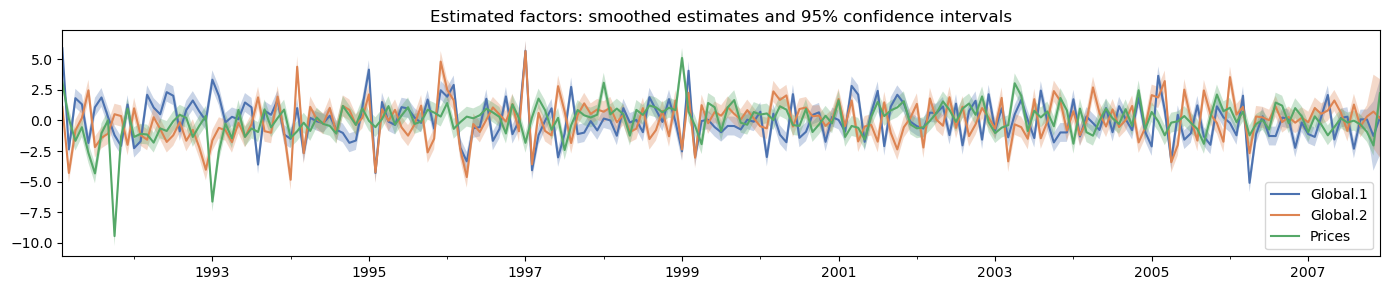

In [22]:
# Get estimates of the global and labor market factors,
# conditional on the full dataset ("smoothed")
#factor_names = ['Global.1', 'Global.2']
#factor_names = ['Global', 'Labor market']
factor_names = ['Global.1', 'Global.2', 'Prices']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
var = pd.concat([results.factors.smoothed_cov.loc[name, name]
                for name in factor_names], axis=1)
std = np.sqrt(var)

crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

## Explanatory power of the factors

* The first global factor explains activity variables (production and turnover) well, as well as labor market variables.
* The second factor loads only on labor market variables and therefore explains them well (not clear if needed taken that the first factor already explains both variables).

In [24]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:3]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                   Variable $R^2$   
0  Production in main construction industry  0.64   
1                Hours worked: construction  0.63   
2               Industrial production index  0.62   
3                         Industry turnover  0.48   
4               Hours worked: manufacturing  0.30   
5                   New orders for industry  0.14   
6       Main construction industry turnover  0.12   
7                      Producer price index  0.03   
8    Consumer price index, excluding energy  0.02   
9    Producer price index, excluding energy  0.01   

     Top ten variables explained by Global.2        \
                                    Variable $R^2$   
0                 Hours worked: construction  0.50   
1   Production in main construction industry  0.47   
2                Hours worked: manufacturing  0.16   
3                Industrial production index  0.14   
4                          Industry turnover  0.11   
5        Main construction industry turnover  0.04   
6                    New orders for industry  0.03   
7     Consumer price index, excluding energy  0.03   
8  New orders for main construction industry  0.02   
9                       Producer price index  0.02   

       Top ten variables explained by Prices        
                                    Variable $R^2$  
0                       Consumer price index  0.94  
1     Consumer price index, excluding energy  0.68  
2                       Producer price index  0.08  
3     Producer price index, excluding energy  0.05  
4   Production in main construction industry   NaN  
5                Industrial production index   NaN  
6  New orders for main construction industry   NaN  
7                    New orders for industry   NaN  
8        Main construction industry turnover   NaN  
9                          Industry turnover   NaN

In [25]:
factors

{'Production in main construction industry': ['Global'],
 'Industrial production index': ['Global'],
 'New orders for main construction industry': ['Global'],
 'New orders for industry': ['Global'],
 'Main construction industry turnover': ['Global'],
 'Industry turnover': ['Global'],
 'Consumer price index': ['Global', 'Prices'],
 'Consumer price index, excluding energy': ['Global', 'Prices'],
 'Producer price index': ['Global', 'Prices'],
 'Producer price index, excluding energy': ['Global', 'Prices'],
 'Hours worked: manufacturing': ['Global'],
 'Hours worked: construction': ['Global'],
 'Gross Domestic Product': ['Global']}

In [26]:
rsquared

,Global.1,Global.2,Prices
Production in main construction industry,0.637396,0.467578,NaN
Industrial production index,0.621071,0.137242,NaN
New orders for main construction industry,0.008065,0.022947,NaN
New orders for industry,0.137185,0.029400,NaN
Main construction industry turnover,0.115037,0.043206,NaN
Industry turnover,0.483275,0.107712,NaN
Consumer price index,0.002340,0.003241,0.940029
"Consumer price index, excluding energy",0.019538,0.027765,0.675318
Producer price index,0.027277,0.020417,0.079002
"Producer price index, excluding energy",0.012392,0.018404,0.045525


## Plotting R^2

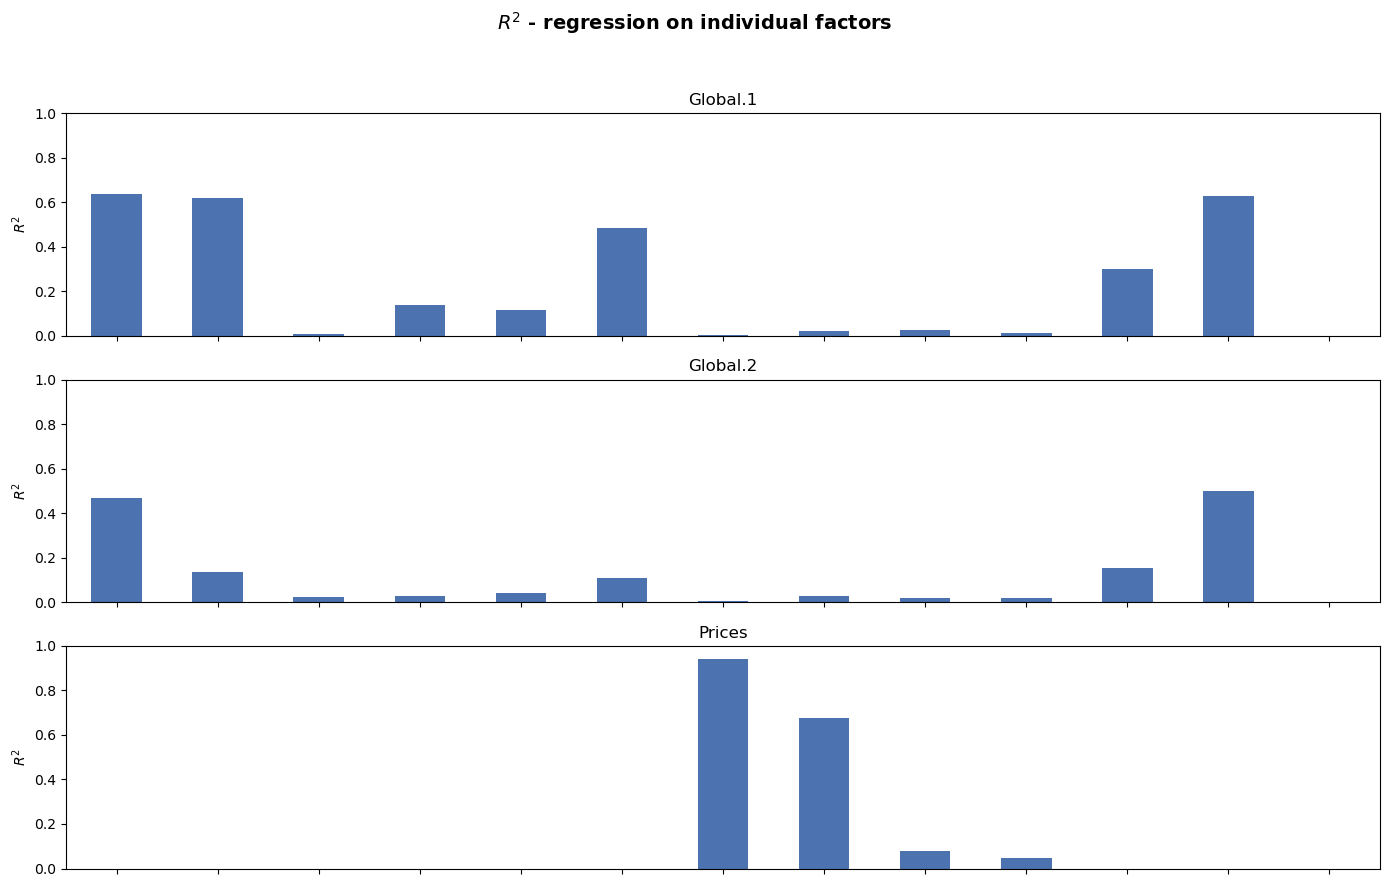

In [27]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

**Explanatory value of all factors to a given variable**

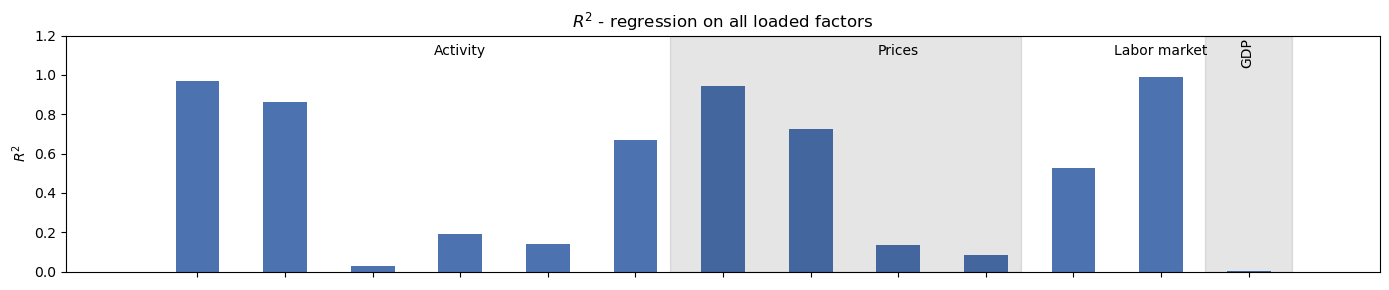

In [28]:
group_counts = defn_m[['Description', 'Group']]
group_counts = group_counts[group_counts['Description'].isin(dta['2008-01-01'].dta_m.columns)]
group_counts = group_counts.groupby('Group', sort=False).count()['Description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i]
        n = end - start
        text = group_counts.index[i]
        #if len(text) > n:
        #    text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for GDP
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate('GDP', (model.k_endog - 1.1, 1.05), ha='left', rotation=90)
    ax.fill_between(np.arange(model.k_endog-1, model.k_endog+1)-0.5, 0, 1.2, color='k', alpha=0.1)
    
    fig.tight_layout();

## Forecasting

* forecast method -> point forecasts only

In [29]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                                            2008-01   2008-02   2008-03
Production in main construction industry  -0.400647  0.443084 -0.176367
Industrial production index                0.094384  0.469120  0.085327
New orders for main construction industry -1.629672  0.604928 -0.353084
New orders for industry                   -0.139849  0.664321  0.109263
Main construction industry turnover       -0.536797  0.146590 -0.397850


In [30]:
# The date of the final forecast
results.forecast('2008-03').T

,2008-01,2008-02,2008-03
Production in main construction industry,-0.400647,0.443084,-0.176367
Industrial production index,0.094384,0.469120,0.085327
New orders for main construction industry,-1.629672,0.604928,-0.353084
New orders for industry,-0.139849,0.664321,0.109263
Main construction industry turnover,-0.536797,0.146590,-0.397850
Industry turnover,0.081360,0.587701,0.161071
Consumer price index,0.143535,0.156298,0.174258
"Consumer price index, excluding energy",0.115663,0.140348,0.159138
Producer price index,0.091177,0.147611,0.119864
"Producer price index, excluding energy",0.054636,0.096335,0.087897


* get_forecast method gives confidence intervals

In [31]:
# point forecast
results.get_forecast('2008-03').predicted_mean['Gross Domestic Product']

2008-01    2.110726
2008-02    1.865883
2008-03    1.730603
Freq: M, Name: Gross Domestic Product, dtype: float64

In [32]:
# lower bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['lower Gross Domestic Product']]

,lower Gross Domestic Product
2008-01,-2.002486
2008-02,-2.385222
2008-03,-2.563989


In [33]:
# upper bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['upper Gross Domestic Product']]

,upper Gross Domestic Product
2008-01,6.223938
2008-02,6.116988
2008-03,6.025195


* predict and get_prediction are more general => in-sample and out-of-sample forecasts

In [34]:
prediction_results = results.get_prediction(start='1991-02', end='2008-03')

In [35]:
prediction_results.predicted_mean['Gross Domestic Product']

1991-02   -13.427022
1991-03   -11.946982
1991-04   -13.176817
1991-05    -2.805860
1991-06    -2.642926
             ...    
2007-11     2.612682
2007-12     2.433122
2008-01     2.110726
2008-02     1.865883
2008-03     1.730603
Freq: M, Name: Gross Domestic Product, Length: 206, dtype: float64

In [36]:
ci = prediction_results.conf_int(alpha=0.05)

In [37]:
ci[['upper Gross Domestic Product']]

,upper Gross Domestic Product
1991-02,-9.402930
1991-03,-8.061148
1991-04,-10.067804
1991-05,0.736378
1991-06,0.782049
...,...
2007-11,5.664984
2007-12,6.144213
2008-01,6.223938
2008-02,6.116988


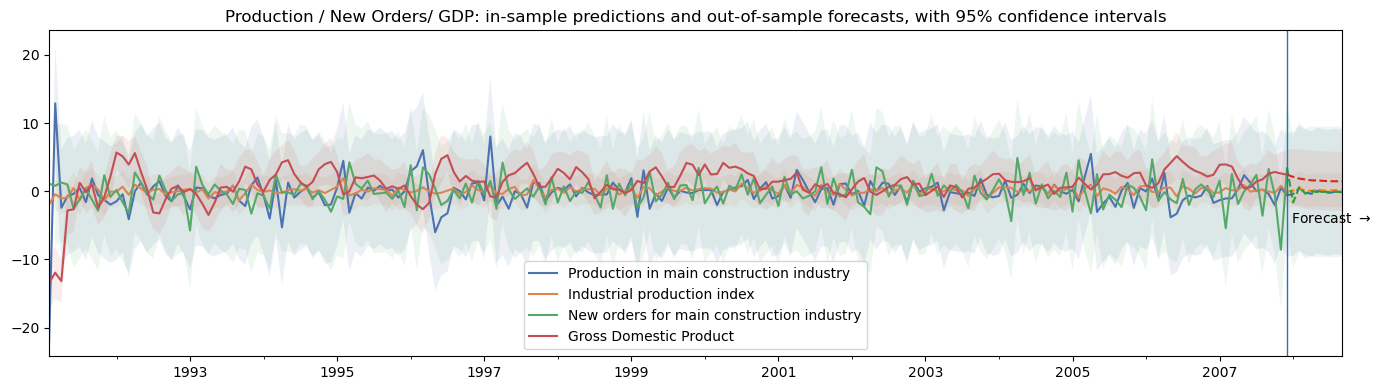

In [38]:
# Create forecasts results objects, through the end of 2008-09
prediction_results = results.get_prediction(start='1991', end='2008-09')

variables = ['Production in main construction industry',
             'Industrial production index',
             'New orders for main construction industry',
             'Gross Domestic Product']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2007-12'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2007-12':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2', 'C3'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2007-12', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2007-12', -4.7))
    ax.set(title=('Production / New Orders/ GDP:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

## GDP forecast

In [39]:
# Get the titles of the variables as they appear in the dataset
gdp_description = 'Gross Domestic Product'

# Compute the point forecasts
#fcast_q = results.forecast('2009-12')[gdp_description].resample('Q').last()
fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[gdp_description].resample('Q').last()

C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_21356\2628977374.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[gdp_description].resample('Q').last()


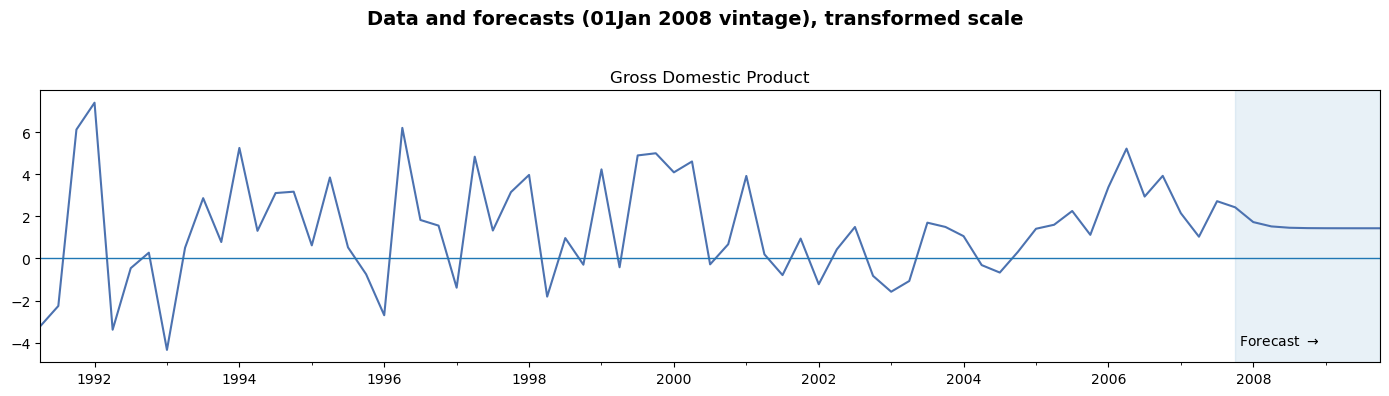

In [40]:
# For more convenient plotting, combine the observed data with the forecasts
plot_q = pd.concat([dta['2008-01-01'].dta_q.loc['1991-04':'2007-09', gdp_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(14, 4))

    # Plot real GDP growth, data and forecasts
    plot_q.plot(ax=axes)
    axes.set(title='Gross Domestic Product')
    axes.hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)
    
    # Show the forecast period
    ylim = axes.get_ylim()
    axes.fill_between(plot_q.loc['2007-10':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
    axes.annotate(r' Forecast $\rightarrow$',
                         ('2007-10', ylim[0] + 0.1 * ylim[1]))
    axes.set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (01Jan 2008 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

## Original GDP forecast (2008-01-01 vintage)

In [41]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('2008-03')[gdp_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (1st of February 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of February 2008) forecast for real GDP growth in 2008Q1: 1.73%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_21356\933967379.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


In [42]:
# The original point forecasts are monthly
point_forecasts_m = results.get_prediction(start='2008-02', end='2008-03').predicted_mean[gdp_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (1st of February 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of February 2008) forecast for real GDP growth in 2008Q1: 1.73%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_21356\274257678.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


## Updated GDP forecast: Jan16 2008 vintage

In [50]:
# Since we will be collecting results for a number of vintages,
# construct a dictionary to hold them, and include the baseline
# results from 01Jan 2008
vintage_results = {'2008-01-01': results}

# Get the updated monthly and quarterly datasets
start = '1991-02'
updated_endog_m = dta['2008-01-16'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDP', 'Description']
updated_endog_q = dta['2008-01-16'].dta_q.loc[start:, [gdp_description]]

# Get the results for Mid Jan 2008 using `apply`
vintage_results['2008-01-16'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

In [51]:
# Print the updated forecast for real GDP growth in 2008Q1
updated_forecasts_q = (
    vintage_results['2008-01-16'].forecast('2008-03')[gdp_description]
                              .resample('Q').last())

print('Mid Jan 2008 forecast for real GDP growth in 2008Q1:'
      f' {updated_forecasts_q["2008Q1"]:.2f}%')

Mid Jan 2008 forecast for real GDP growth in 2008Q1: 1.39%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_21356\4024012319.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  vintage_results['2008-01-16'].forecast('2008-03')[gdp_description]


## Updated GDP forecast: 01Jan2008 - 01Apr 2008 vintages

In [45]:
# Get the updated monthly and quarterly datasets
start = '1991-02'
updated_endog_m = dta['2008-04-01'].dta_m.loc[start:, :]
gdp_description = defn_q.loc['GDP', 'Description']
updated_endog_q = dta['2008-04-01'].dta_q.loc[start:, [gdp_description]]

# Get the results for 01-April 2008 using `apply`
vintage_results['2008-04-01'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

In [53]:
vintage_results

{'2008-01-01': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x1317765bb80>,
 '2008-01-16': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x1317fee5220>,
 '2008-02-01': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x1317d04edc0>,
 '2008-02-16': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x1317d04e9d0>,
 '2008-03-01': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x1317ff1cbe0>,
 '2008-03-16': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x13102dc9d60>,
 '2008-04-01': <statsmodels.tsa.statespace.mlemodel.MLEResultsWrapper at 0x13102df5f40>}

In [52]:
# Apply our results to the remaining vintages
for vintage in ['2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Get updated data for the vintage
    updated_endog_m = dta[vintage].dta_m.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [gdp_description]]

    # Get updated results for for the vintage
    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

In [59]:
# Compute forecasts for each vintage
forecasts = {vintage: res.get_prediction(start='2008-02', end='2008-03').predicted_mean[gdp_description]
                         .resample('Q').last().loc['2008Q1']
             for vintage, res in vintage_results.items()}
# Convert to a Pandas series with a date index
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='D'))
    
# Print our forecast for 2008Q1 real GDP growth across all vintages
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2008Q1:'
          f' {value:.2f}%')

2008-01-01 forecast for real GDP growth in 2008Q1: 1.73%
2008-01-16 forecast for real GDP growth in 2008Q1: 1.39%
2008-02-01 forecast for real GDP growth in 2008Q1: 1.38%
2008-02-16 forecast for real GDP growth in 2008Q1: 1.58%
2008-03-01 forecast for real GDP growth in 2008Q1: 2.27%
2008-03-16 forecast for real GDP growth in 2008Q1: 4.54%
2008-04-01 forecast for real GDP growth in 2008Q1: 4.84%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_21356\4142900771.py:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  forecasts = {vintage: res.get_prediction(start='2008-02', end='2008-03').predicted_mean[gdp_description]


## News

In [61]:
# Compute the news and impacts on the real GDP growth forecast
# for 2008Q1, between the March and February vintages
news = vintage_results['2008-01-16'].news(
    vintage_results['2008-01-01'], impact_date='2008-03',
    impacted_variable=gdp_description,
    comparison_type='previous')

# The `summary` method summarizes all updates. Here we aren't
# showing it, to save space.
news.summary()

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    -0.90
1    -0.46
2     3.39
3    -0.74
Name: observed, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     1.11
1     0.67
2    -0.46
3     1.28
Name: forecast (prev), dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      News                                     
===============================================================================
Model:                DynamicFactorMQ   Original sample:                1991-02
Date:                Wed, 12 Mar 2025                                 - 2007-12
Time:                        16:54:22   Update through:                 2007-12
                                        # of revisions:                      14
                                        # of new datapoints:                  4
                 Impacts for [impacted variable = Gross Domestic Product]                 
==========================================================================================
impact date estimate (prev) impact of revisions impact of news total impact estimate (new)
------------------------------------------------------------------------------------------
    2008-03            1.73                0.02          -0.36        -0.34           1.39
                              News from updated observations:                              
===========================================================================================
update date                         updated variable   observed forecast (prev)        news
-------------------------------------------------------------------------------------------
    2007-11              Industrial production index      -0.90            1.11       -2.00
                                   Industry turnover      -0.46            0.67       -1.13
                             New orders for industry       3.39           -0.46        3.84
            Production in main construction industry      -0.74            1.28       -2.03
===========================================================================================
"""

In [62]:
# We can re-arrange the `details_by_impact` table to show the new
# observations with the top ten impacts (in absolute value)
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

observed  \
update date updated variable                                     
2007-11     Industrial production index                  -0.90   
            Industry turnover                            -0.46   
            New orders for industry                       3.39   
            Production in main construction industry     -0.74   

                                                      forecast (prev)  news  \
update date updated variable                                                  
2007-11     Industrial production index                          1.11 -2.00   
            Industry turnover                                    0.67 -1.13   
            New orders for industry                             -0.46  3.84   
            Production in main construction industry             1.28 -2.03   

                                                      weight  impact  
update date updated variable                                          
2007-11     Industrial production index                 0.16   -0.31  
            Industry turnover                           0.07   -0.08  
            New orders for industry                     0.01    0.04  
            Production in main construction industry    0.00   -0.01

**All vintages**

In [63]:
news_results = {}
vintages = ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']
impact_date = '2008-03'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (February 2008) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=gdp_description,
        comparison_type='previous')

In [64]:
news_results['2008-04-01'].details_by_impact

observed  \
impact date impacted variable      update date updated variable                                       
2008-03     Gross Domestic Product 2008-01     Hours worked: construction                 10.558428   
                                               Hours worked: manufacturing                -0.914785   
                                               Main construction industry turnover        14.978536   
                                               New orders for main construction industry  18.747448   
                                   2008-02     Producer price index                        0.572599   
                                               Producer price index, excluding energy      0.444643   
                                   2008-03     Consumer price index                        0.377715   

                                                                                          forecast (prev)  \
impact date impacted variable      update date updated variable                                             
2008-03     Gross Domestic Product 2008-01     Hours worked: construction                       10.250771   
                                               Hours worked: manufacturing                       0.261681   
                                               Main construction industry turnover               8.021023   
                                               New orders for main construction industry         4.834193   
                                   2008-02     Producer price index                              0.074072   
                                               Producer price index, excluding energy            0.115726   
                                   2008-03     Consumer price index                              0.152426   

                                                                                               news  \
impact date impacted variable      update date updated variable                                       
2008-03     Gross Domestic Product 2008-01     Hours worked: construction                  0.307657   
                                               Hours worked: manufacturing                -1.176465   
                                               Main construction industry turnover         6.957512   
                                               New orders for main construction industry  13.913255   
                                   2008-02     Producer price index                        0.498526   
                                               Producer price index, excluding energy      0.328917   
                                   2008-03     Consumer price index                        0.225289   

                                                                                            weight  \
impact date impacted variable      update date updated variable                                      
2008-03     Gross Domestic Product 2008-01     Hours worked: construction                 0.113092   
                                               Hours worked: manufacturing                0.100555   
                                               Main construction industry turnover        0.001147   
                                               New orders for main construction industry -0.000481   
                                   2008-02     Producer price index                       0.408297   
                                               Producer price index, excluding energy     0.696338   
                                   2008-03     Consumer price index                      -0.029304   

                                                                                            impact  
impact date impacted variable      update date updated variable                                     
2008-03     Gross Domestic Product 2008-01     Hours worked: construction                 0.034794  
                               

## Impacts by group

In [65]:
group_impacts = {'2008-01-01': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='Description')
                 .drop('Description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('Group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2008-01-01'] = group_impacts['2008-01-16'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
#(group_impacts.T
#    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
#    .round(2).iloc[:, 1:])

pd.concat(
    [
        group_impacts.T,
        group_impacts.sum(axis=1).rename('Total impact on 2008Q1 forecast').to_frame().T
    ],
    axis=0
).round(2).iloc[:, 1:]

,2008-01-16,2008-02-01,2008-02-16,2008-03-01,2008-03-16,2008-04-01
Activity,-0.36,0.00,-0.03,-0.00,1.89,0.00
Prices,0.00,-0.01,0.00,0.64,0.06,0.43
Labor market,0.00,-0.00,0.15,0.05,0.00,-0.08
Total impact on 2008Q1 forecast,-0.36,-0.02,0.12,0.70,1.95,0.34


**Impacts by group: graphical illustration**

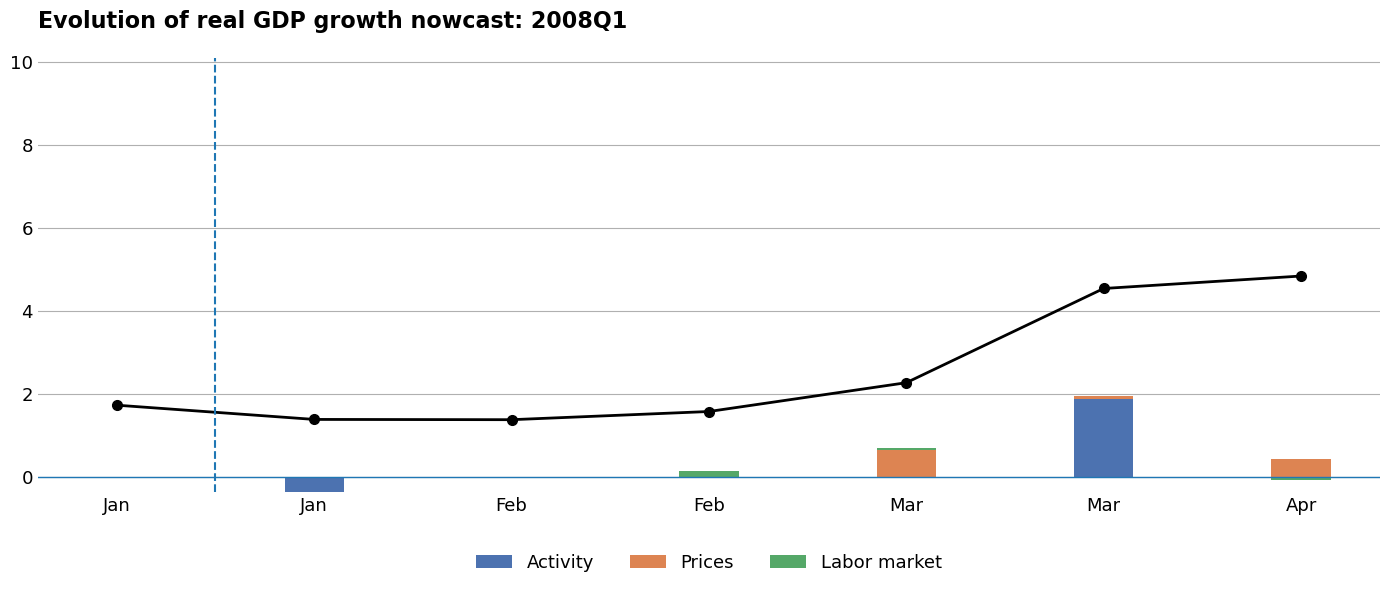

In [66]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax);

    # Line plot showing the forecast for real GDP growth in 2008Q1 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)

    # y-ticks
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2008Q1', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]
    
    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 22), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 22), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout();